# Exploring hyperspectral data from EnMAP

## Import libs and start cluster

In [ ]:
import rioxarray as riox
import xarray as xr
import cartopy.crs as ccrs

#plotting libs
import geoviews as gv
import hvplot.xarray
import holoviews as hv
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import geopandas as gpd

#ml libs
from xgboost import XGBClassifier
from sklearn_xarray import wrap
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import StandardScaler


Start up a local dask cluster. If you need to scale to multiple instances have a look at [coiled.io](www.coiled.io)

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8)
client = Client(cluster)
cluster.dashboard_link


Before you go anywhere you need to register on the EnMAP user portal and order the images you need. For a summary of how to do this have a look at [here](https://mastodon.online/@henningbuddenbaum/109321164064585359). I ordered my files as L2A surface reflectance deleiver in the BIL format. This code will probably work for other products and file formats but I have only tested it on this.

Once your order is ready you will recieve a link. This can be downloaded using an ftp clinet like Filezilla or using the code below:

## Download data

In [ ]:
from ftplib import FTP_TLS
#address of the dlr ftp server
ftps = FTP_TLS('download.dsda.dlr.de')
# login after securing control channel
#your username and password
ftps.login('glennwithtwons-cat1distributor', 'password')           
# switch to secure data connection.. 
# IMPORTANT! Otherwise, only the user and password is encrypted and
# not all the file data.
ftps.prot_p()          
#list files
ftps.retrlines('LIST')

In [ ]:
#the files we want
filenames = ['dims_op_oc_oc-en_700333133_1.tar.gz','dims_op_oc_oc-en_700333133_2.tar.gz']

for filename in filenames:
    print('Opening local file ' + filename)
    with open(filename, 'wb') as myfile:
        ftps.retrbinary('RETR %s' % filename, myfile.write)
    ftps.close()


Now you need to do lots of unzipping to get to the files you want. What we need are the .BIL and .HDR files. Move all of these into a single folder and `cd` to this folder

Once on the folder we can combine the files we want into a mosaic using `gdal`

In [ ]:
!gdalbuildvrt -srcnodata "-32768" ct_mosaic.vrt *.BIL

## Read in your data

In [3]:
#read in a single file from which we can get some metadata
#we will assign this metadata to the mosaic xarray dataset
#we do this bc some of the metadata is lost when making the vrt with gdal
xtemp = riox.open_rasterio("data/cp/ct1.BIL", chunks={'x':-1,'y':-1,'band':1})
#read in the mosaic
xds = riox.open_rasterio("data/cp/ct_mosaic.vrt", chunks={'x':-1,'y':-1,'band':1})

#we want to index the bands by wavelength
xds = xds.assign_coords({'wavelength':xtemp.wavelength})
xds = xds.set_index(band="wavelength")

#and drop noisy bands
xds = xds.where(((xds.band > 418) & (xds.band < 1290)) |\
             ((xds.band > 1520) & (xds.band < 1728)) |\
             ((xds.band > 1970) & (xds.band < 2450)))

## Initial visualizations

In [9]:
#set the crs foer plotting. we can get the crs using this command:
#xds.rio.crs
crs=ccrs.epsg(32734)

#RGB bands
xds_rgb = xds.sel(band=[660, 570, 480], method="nearest")
#set no data
xds_rgb = xds_rgb.where(xds_rgb != -32768.)

#rescale data 
stretch=0.98
min_val = xds_rgb.quantile(1 - stretch,dim=['x','y'])
max_val = xds_rgb.quantile(stretch,dim=['x','y'])
xds_rgb = ((xds_rgb - min_val) / (max_val - min_val)).clip(0, 1)

### Plot RGB

In [10]:
xds_rgb.hvplot.rgb(x="x", y="y", bands="band", data_aspect=1,rasterize=True)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B)

### Plot ndvi

In [13]:
red = xds.sel(band=659, method="nearest")
nir = xds.sel(band=848, method="nearest")
ndvi = (nir - red) / (nir + red)
ndvi.hvplot(x="x", y="y", clim=(0,1), data_aspect=1, rasterize=True, cmap='YlGn')

:DynamicMap   []
   :Image   [x,y]   (value)

### Plot pixel spectrum

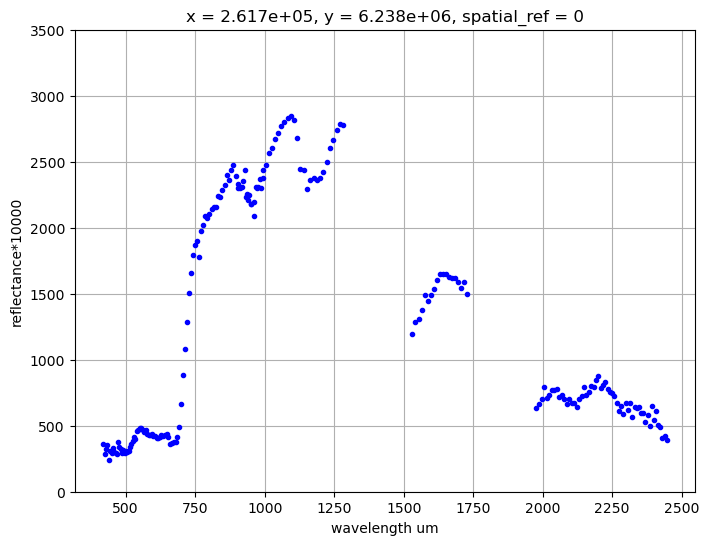

In [17]:
#Plot the spectral signature at point
plt.figure(figsize=(8,6))
xds.sel(x=2.617e5,y=6.238e6, method="nearest").plot.line('b.')
plt.ylabel('reflectance*10000')
plt.xlabel('wavelength um')
plt.ylim(0, 3500)
plt.grid()

## Extract point values

In [4]:
# a simple data set of about 200 points classified as either land, sea or cloud
points = gpd.read_file("data/cp/ctlc.gpkg")
points.head()

,code,geometry
0,0,POINT (261847.635 6210969.995)
1,0,POINT (261058.082 6224448.797)
2,0,POINT (263765.122 6206289.072)
3,0,POINT (267318.111 6226704.664)
4,0,POINT (263934.312 6201833.736)


In [5]:
#get x and y coords and put into a xarray
points['x'] = points['geometry'].x
points['y'] = points['geometry'].y
x_indexer = xr.DataArray(points['x'], dims=["index"])
y_indexer = xr.DataArray(points['y'], dims=["index"])

#select data at x and y coords
xdp = xds.sel(x=x_indexer,y=y_indexer,method='nearest')

#merge with points and add labels as variable
points = points.to_xarray()
xdp= xdp.to_dataset(name='refl').merge(points['code'])

### Plot mean spectra for a class 


In [50]:
#select a single code (land)
xdo=xdp.where(xdp['code']==0,drop=False)

#plot spectra and overlay plot of mean   
xdo['refl'].mean(['index']).hvplot.scatter(x='band',y='refl', color='indianred')

:Scatter   [band]   (refl)

## Machine Learning with Dask-ML

### XGBoost

sklearn-xarray is a great library for applying sklearn models to xarray data and keeping all the dims and coordinates intact. It also works with dask-ml enabling scalable analyses. I could not get it to work with XGBoost-dask, so we do it the hard way here, reassiging the coords to predictions.

In [ ]:
#using dask we can scale this to very large datasets
import xgboost as xgb
clf = xgb.dask.DaskXGBClassifier(n_estimators=10, tree_method="hist")

xdml=xdp.transpose().chunk({'band':-1,'index':70})

#fit model
clf.client = client  # assign the client
#fit on the dask arrays inside xarrays (accessed with .data)
clf.fit(xdml['refl'].data, xdml['code'].data)


In [ ]:
#predit over entire image (2 mosaiced enmap scenes)
xdpred = xds.stack(index=("x", "y")).transpose().chunk({'band':-1,'index':1e4})
#predict on the dask arrays inside xarrays (accessed with .data)
preds = clf.predict(xdpred.data)

`preds` is just a dask-array so we need to turn it back into an xarray

In [ ]:
#merge predcitons into original xarray image and add as a variable
xdpred = xdpred.assign_coords(preds=("index", preds))
xdpred = xdpred.to_dataset(name='refl')
xdpred = xdpred.reset_coords(names='preds')
xdpred = xdpred.unstack().transpose()


### Plot XGBoost predictions over the entire image mosaic

In [ ]:
#plot XGBoost preds
xdpred['preds'].hvplot(x="x", y="y", data_aspect=1,rasterize=True,cmap='Dark2')

### PCA

here we used sklearn-xarray with the dask-ml PCA. Scalable analyses using the familiar sklearn API on xarray datasets that preserves all the xarray structure. tasty

In [4]:
#clip to table mountain
xdpca = xds.rio.clip_box(
    minx=2.582e5,
    miny=6.235e6,
    maxx=2.641e5,
    maxy=6.242e6,
)
xdpca = xdpca.stack(index=("x", "y")).transpose().chunk({'band':-1,'index':1e4})


In [5]:
#a sklearn pipeline that we can add step to if desired
pipeline_pca = Pipeline([
    ('pca', wrap(PCA(n_components=3), reshapes='band'))])

#fit and apply#fill with 0 to get it to work
#this is silly and needs to be done properly
dpca = pipeline_pca.fit_transform(xdpca.fillna(0))
#reshape
dpca = dpca.unstack().transpose().load()

In [6]:
#rescale to make it look nice
stretch=0.99
min_val = dpca.quantile(1 - stretch,dim=['x','y'])
max_val = dpca.quantile(stretch,dim=['x','y'])
dpca = ((dpca - min_val) / (max_val - min_val)).clip(0, 1)

#plot
#dpca.hvplot.rgb(x="x", y="y", bands="band", data_aspect=1,rasterize=True)

### Plot PCA with hi-res RGB background

In [7]:
#define crs for mapping
crsx=ccrs.epsg(32734)
#use esri sat image background
tiles = gv.tile_sources.EsriImagery
#download tiles
bground = gv.util.get_tile_rgb(tiles, bbox=(18.33, -34.036, 18.492,  -33.921), zoom_level=12).opts(projection=ccrs.PlateCarree())

In [8]:
#plot with a background of hi-res RGB
bground *\
dpca.hvplot.rgb(x="x", y="y", bands="band", data_aspect=1,projection=ccrs.PlateCarree(),
           crs=crsx, geo=True, alpha=0.7)

:Overlay
   .RGB.I  :RGB   [Longitude,Latitude]   (R,G,B)
   .RGB.II :RGB   [x,y]   (R,G,B)